In [1]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import os
from PIL import Image, UnidentifiedImageError
import shutil

# Configuration
IMG_SIZE = (28, 28)
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.4
SEED = 42
ROOT_PATH = ''
DATASET_PATH = os.path.join(ROOT_PATH,"raw_data")
CORRUPT_PATH = os.path.join(ROOT_PATH,"corrupt_images")
os.makedirs(CORRUPT_PATH, exist_ok=True)

for root, dirs, files in os.walk(DATASET_PATH):
    for file in files:
        ext = os.path.splitext(file)[1].lower()
        if ext in [".jpg", ".jpeg", ".png", ".bmp", ".gif"]:
            path = os.path.join(root, file)
            try:
                with Image.open(path) as img:
                    img.verify()  # Check integrity
            except (UnidentifiedImageError, OSError, IOError) as e:
                # Move the corrupt image
                print(f"Corrupt image found: {path} — moving to {CORRUPT_PATH}")
                dest_path = os.path.join(CORRUPT_PATH, os.path.relpath(path, DATASET_PATH))
                os.makedirs(os.path.dirname(dest_path), exist_ok=True)
                shutil.move(path, dest_path)

LANDMARK_DIR = os.path.join(ROOT_PATH,"data")
RAW_IMAGE_DIR = os.path.join(ROOT_PATH,"raw_data")
FILTERED_IMAGE_DIR = os.path.join(ROOT_PATH,"filtered_raw_data")
DATASET_PATH = FILTERED_IMAGE_DIR
# Supported image extensions
IMAGE_EXTENSIONS = ['.jpg', '.jpeg', '.png', '.bmp']

# Create filtered output structure
os.makedirs(FILTERED_IMAGE_DIR, exist_ok=True)

for class_name in os.listdir(LANDMARK_DIR):
    if class_name == 'debug':
        continue
    landmark_class_dir = os.path.join(LANDMARK_DIR, class_name)
    raw_class_dir = os.path.join(RAW_IMAGE_DIR, class_name)
    filtered_class_dir = os.path.join(FILTERED_IMAGE_DIR, class_name)
    os.makedirs(filtered_class_dir, exist_ok=True)

    for file in os.listdir(landmark_class_dir):
        if not file.endswith("_landmarks.json"):
            continue

        # Get base filename without "_landmarks.json"
        base_name = file.replace("_landmarks.json", "")

        # Look for corresponding image in raw directory
        for ext in IMAGE_EXTENSIONS:
            image_file = os.path.join(raw_class_dir, base_name + ext)
            if os.path.exists(image_file):
                # Copy to filtered folder
                shutil.copy(image_file, os.path.join(filtered_class_dir, os.path.basename(image_file)))
                break

# Load training dataset with validation split
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_PATH,
    validation_split=VALIDATION_SPLIT,
    subset="training",
    seed=SEED,
    color_mode="grayscale",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)
num_classes = len(train_ds.class_names)
label_map = train_ds.class_names

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_PATH,
    validation_split=VALIDATION_SPLIT,
    subset="validation",
    seed=SEED,
    color_mode="grayscale",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

test_ds = val_ds.shard(2,0)
val_ds = val_ds.shard(2,1)
# Normalize pixel values to [0, 1]
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))
# Cache and prefetch for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


Found 5643 files belonging to 51 classes.
Using 3386 files for training.
Found 5643 files belonging to 51 classes.
Using 2257 files for validation.


In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, BatchNormalization,Input
from tensorflow.keras.layers import Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
model = Sequential([
    Input((28, 28, 1)),
    Conv2D(16, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.1),

    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),

    GlobalAveragePooling2D(),
    Flatten(),

    Dense(128, activation='relu'),
    Dropout(0.2),

    Dense(num_classes, activation='softmax')
])

model.compile(optimizer=Adam(1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [3]:
history = model.fit(train_ds, validation_data=val_ds, epochs=50)

Epoch 1/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 19s 67ms/step - accuracy: 0.0285 - loss: 3.9030 - val_accuracy: 0.0188 - val_loss: 3.9602
Epoch 2/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.0746 - loss: 3.4015 - val_accuracy: 0.0205 - val_loss: 4.2724
Epoch 3/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.0855 - loss: 3.2238 - val_accuracy: 0.0232 - val_loss: 4.3350
Epoch 4/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.0961 - loss: 3.1364 - val_accuracy: 0.0259 - val_loss: 3.9981
Epoch 5/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.1320 - loss: 3.0458 - val_accuracy: 0.0473 - val_loss: 3.6321
Epoch 6/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.1539 - loss: 2.9616 - val_accuracy: 0.1437 - val_loss: 3.1492
Epoch 7/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.1671 - loss: 2.8833 - val_accuracy: 0.1375 - val_loss: 3.1823
Epoch 8/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.2108 - loss: 2.8134 - val_accuracy: 

In [4]:
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 0.3699 - loss: 2.2056
Test Accuracy: 0.3817
Test Loss: 2.2056


In [5]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

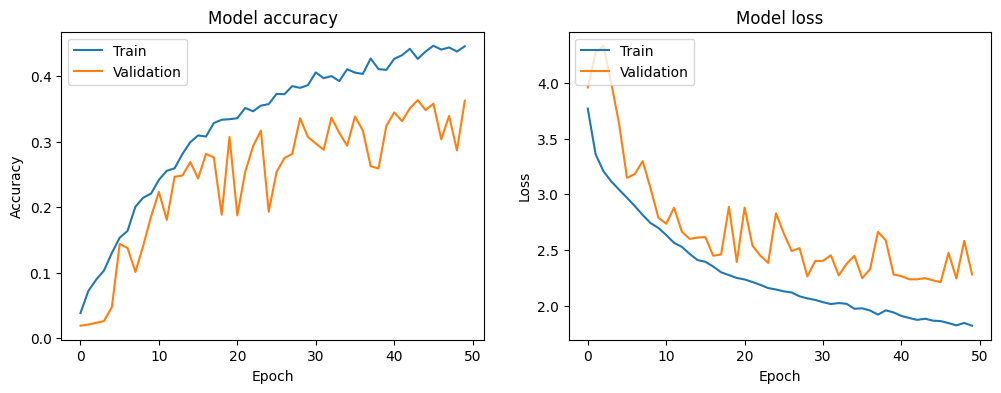

In [6]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

c:\Users\chris\.conda\envs\ASLR\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\chris\.conda\envs\ASLR\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\chris\.conda\envs\ASLR\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


               precision    recall  f1-score   support

            A      0.083     0.053     0.065        19
            B      0.091     0.037     0.053        27
            C      0.050     0.043     0.047        23
            D      0.000     0.000     0.000        21
            E      0.361     0.433     0.394        30
            F      0.188     0.120     0.146        25
            G      0.105     0.129     0.116        31
            H      0.286     0.138     0.186        29
            I      0.083     0.227     0.122        22
            J      0.162     0.250     0.197        24
            K      0.000     0.000     0.000        32
            L      0.116     0.192     0.145        26
            M      0.333     0.116     0.172        43
            N      0.067     0.071     0.069        28
            O      0.048     0.038     0.043        26
            P      0.000     0.000     0.000        24
            Q      0.122     0.278     0.169        18
         

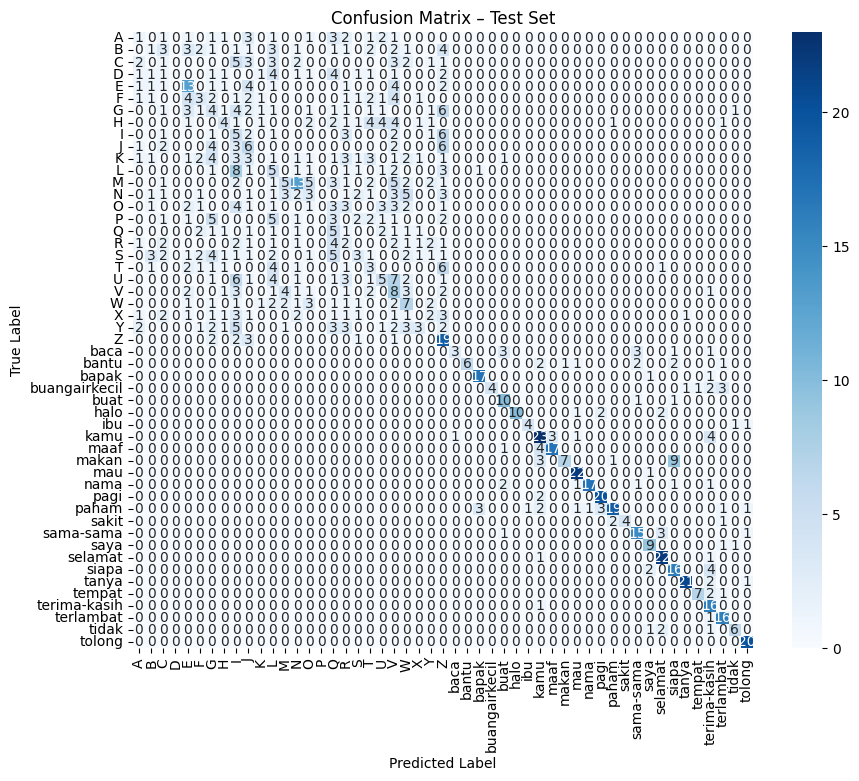

In [7]:
y_true, y_pred = [], []
target_names = [label_map[i] for i in range(len(label_map))]
for X_batch, y_batch in test_ds:
    y_true.append(y_batch.numpy())

    batch_pred = model.predict(X_batch, verbose=0)
    y_pred.append(np.argmax(batch_pred, axis=1))

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

print(classification_report(
    y_true, y_pred,
    digits=3,                            
    target_names=target_names 
))

cm = confusion_matrix(y_true, y_pred, labels=range(len(label_map)))
labels = [label_map[i] for i in range(len(label_map))]

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix – Test Set")
plt.show()